In [ ]:
import copy
import numpy as np

In [ ]:
def khatri_rao(matrices):
    n_columns = matrices[0].shape[1]
    n_factors = len(matrices)

    start = ord('a')
    common_dim = 'z'
    target = ''.join(chr(start + i) for i in range(n_factors))
    source = ','.join(i+common_dim for i in target)
    operation = source+'->'+target+common_dim
    return np.einsum(operation, *matrices).reshape((-1, n_columns))


In [ ]:
def unfold(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order='F')

In [ ]:
def recomposition(matrices):
    n = len(matrices)
    s = ''
    for i in range(n):
        s += chr(ord('A') + i)
        s += 'z'
        if i != n - 1:
            s += ','
        else:
            s += '->'
            for j in range(n):
                s += chr(ord('A') + j)
    return np.einsum(s, *matrices)

In [ ]:
def cp_decomposition(X: np.ndarray, r: int, iter_max : int):
    d = X.ndim
    shape = X.shape
    matrices = [np.random.normal(0, 1, (shape[i], r)) for i in range(d)]
    
    nz_pos = np.where(X != 0)
    nz_X = np.zeros(shape)
    nz_X[nz_pos] = 1
    X_hat = np.zeros(shape)

    iters_list = []
    loss_list = []
    for iters in range(1,iter_max+1):
        for dim in range(d):
            mm = copy.deepcopy(matrices)
            mm.pop(dim)
            n = shape[dim]
            kr_result = khatri_rao(mm[::-1]).T
            # print(var1.shape)
            kr2 = khatri_rao([kr_result, kr_result])
            vl = np.matmul(kr2, unfold(nz_X, dim).T).reshape([r, r, n])
            kr_X = np.matmul(kr_result, unfold(X, dim).T)
            for i in range(n):
                v_lambda = vl[:, :, i]
                inv_lambda = np.linalg.inv((v_lambda + v_lambda.T) / 2)
                matrices[dim][i, :] = np.matmul(inv_lambda, kr_X[:, i])
        X_hat = recomposition(matrices)
        loss = np.sum(np.square(X[nz_pos] - X_hat[nz_pos])) / X[nz_pos].shape[0]
        print('iter = ', iters, ' loss = ', loss)
        iters_list.append(iters)
        loss_list.append(loss)
        if iters >= 55:
            return (iters_list, loss_list,matrices,X_hat)
    return (iters_list, loss_list,matrices,X_hat)


In [ ]:
def decomposition(X, epsilon=0.0001):
    d = X.ndim
    shape = X.shape
    size = X.size
    q = (epsilon / np.sqrt(d - 1)) * np.linalg.norm(X)  # truncation threshold
    tt_ranks = [1]
    c = X
    tt_cores = []
    for k in range(1, d):
        ttt = int(tt_ranks[k - 1] * X.shape[k - 1])
        c = np.reshape(c, (ttt, c.size // ttt))

        # computing SVD
        u, sigma, v = np.linalg.svd(c)
        q_rank = 1
        b = np.matmul((sigma[:q_rank] * u[:, :q_rank]), v[:q_rank, :])
        while np.linalg.norm(c - b) > q and q_rank != len(sigma):
            q_rank += 1
            b = np.matmul((sigma[:q_rank] * u[:, :q_rank]), v[:q_rank, :])
        tt_ranks.append(q_rank)
        tt_cores.append(np.reshape(u[:, :q_rank], (tt_ranks[k - 1], X.shape[k - 1], tt_ranks[k])))
        c = np.matmul(np.diag(sigma[:q_rank]), v[:q_rank, :])

    temp_core = np.zeros((c.shape[0], c.shape[1], 1))
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            temp_core[i, j, 0] = c[i, j]
    tt_cores.append(temp_core)

    # computing the compression ratio
    num_data = 0
    for core in tt_cores:
        num_data += core.size
    compression_ratio = num_data / size

    # computing the Frobenious-norm
    v = np.kron(tt_cores[0][:, 0, :], tt_cores[0][:, 0, :])
    for i in np.arange(1, shape[0]):
        v += np.kron(tt_cores[0][:, i, :], tt_cores[0][:, i, :])

    for k in np.arange(1, d):
        temp_res = v @ np.kron(tt_cores[k][:, 0, :], tt_cores[k][:, 0, :])
        for i in np.arange(1, shape[k]):
            temp_res += v @ np.kron(tt_cores[k][:, i, :], tt_cores[k][:, i, :])
        v = temp_res

    return (np.sqrt(round(v[0][0], 10)), compression_ratio)




In [ ]:
import numpy as np



In [ ]:
a = np.load('a.npy')

In [ ]:
b = a.reshape((8,8,8,4234))

In [ ]:
b1,b2 = np.split(b,[4000],axis=3)
print(b1.shape,b2.shape)

(8, 8, 8, 4000) (8, 8, 8, 234)


In [ ]:
c = b1.reshape((8,8,8,8,5,5,5,4))

In [ ]:
x,y = ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55], [1.0742584699540814, 0.07444849123497774, 0.05458113507195184, 0.05070665742475327, 0.048695266659335275, 0.04735720417091977, 0.04642198493105185, 0.04579004085498526, 0.045359122131294706, 0.045046150055716244, 0.04480189520689821, 0.044601300080109776, 0.044431076776872865, 0.044283191921119555, 0.04415250062984012, 0.04403567044797473, 0.04393043667413324, 0.0438351185374414, 0.04374829878589336, 0.04366864070422428, 0.043594847873710964, 0.04352570148751781, 0.04346009798716196, 0.0433970583127877, 0.0433357192324258, 0.043275325709313466, 0.04321523573801694, 0.043154939611882964, 0.04309408889505224, 0.043032526459509925, 0.042970307465831116, 0.04290770251150923, 0.04284517809280667, 0.0427833544300887, 0.04272294482670889, 0.04266468239243027, 0.042609241676561355, 0.04255717013280186, 0.042508844633636605, 0.04246444914293067, 0.04242396334117272, 0.04238717402397254, 0.04235372449867033, 0.04232318808723979, 0.04229513482694902, 0.04226917295291397, 0.0422449657404748, 0.042222232792615874, 0.042200744272443455, 0.042180313207230494, 0.04216078821034277, 0.04214204740855241, 0.04212399365675409, 0.042106550833758506, 0.042089660881882325])

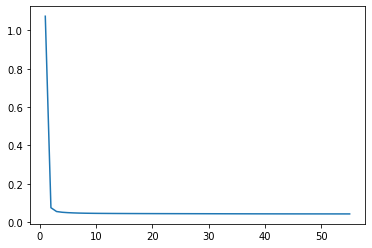

In [ ]:
import matplotlib.pyplot as plt
plt.plot(x,y)
plt.show()

In [ ]:
i_list,l_list,matrices,X_hat = cp_decomposition(b,50)

iter =  1  loss =  0.23096221042996182
iter =  2  loss =  0.038136136478740396
iter =  3  loss =  0.03338706972975817
iter =  4  loss =  0.03149663819296584
iter =  5  loss =  0.030414580142958957
iter =  6  loss =  0.029688941074906283
iter =  7  loss =  0.029166756714763247
iter =  8  loss =  0.028773720570376634
iter =  9  loss =  0.028465589455713463
iter =  10  loss =  0.028214035841551192
iter =  11  loss =  0.02800102381507936
iter =  12  loss =  0.027815329005715005
iter =  13  loss =  0.027649867358640945
iter =  14  loss =  0.027500407811908736
iter =  15  loss =  0.027364472064062378
iter =  16  loss =  0.027240506393529575
iter =  17  loss =  0.027127380006723694
iter =  18  loss =  0.027024115700063564
iter =  19  loss =  0.02692978624065081
iter =  20  loss =  0.026843502494991574
iter =  21  loss =  0.026764426227801997
iter =  22  loss =  0.0266917767613005
iter =  23  loss =  0.026624830589908978
iter =  24  loss =  0.026562920639685742
iter =  25  loss =  0.0265054380

In [ ]:
flatt = X_hat.reshape(2167808)
miss,hit = 0,0
for t in flatt:
  if t > 0.5:
    miss += 1
  else:
    hit += 1
print("hit:{},miss:{},total:{},rate:{}".format(hit,miss,hit+miss,hit/(hit+miss)))

hit:2162933,miss:4875,total:2167808,rate:0.9977511846067548


In [ ]:
data_621 = np.load('621.npy')
print(data_621.shape)

data1,data2 = np.split(data_621,[1600000])
print(data1.shape)

(1765368,)
(1600000,)


In [ ]:
tensor621 = data1.reshape(512,5,5,5,5,5)

In [ ]:
i_list_1,l_list_1,matrices_1,X_hat_1 = cp_decomposition(tensor621,30)

iter =  1  loss =  2.877999728003473e-06
iter =  2  loss =  6.59299171559197e-11
iter =  3  loss =  1.1739032200174284e-08
iter =  4  loss =  1.687858943972179e-09
iter =  5  loss =  9.647414130237569e-09
iter =  6  loss =  2.3996093912568345e-09
iter =  7  loss =  2.476299110745613e-09
iter =  8  loss =  3.5803949622658096e-08
iter =  9  loss =  4.449327476897885e-10
iter =  10  loss =  2.350039840342869e-09
iter =  11  loss =  1.0917157631475742e-09
iter =  12  loss =  1.1792918457779787e-09
iter =  13  loss =  1.5968257343554862e-09
iter =  14  loss =  1.953322386621427e-09
iter =  15  loss =  3.898573848279462e-12
iter =  16  loss =  3.0797784064181107e-06
iter =  17  loss =  3.3422396772471034e-10
iter =  18  loss =  2.822084580558633e-07
iter =  19  loss =  8.179273700237942e-12
iter =  20  loss =  4.35812155321547e-06
iter =  21  loss =  2.2274948405108563e-10
iter =  22  loss =  1.7938073451922413e-06
iter =  23  loss =  5.378456901072222e-10
iter =  24  loss =  1.7302758921732

In [ ]:
flatt = X_hat_1.reshape(2167808)
miss,hit = 0,0
for t in flatt:
  if t > 0.5:
    miss += 1
  else:
    hit += 1
print("hit:{},miss:{},total:{},rate:{}".format(hit,miss,hit+miss,hit/(hit+miss)))

hit:1599419,miss:581,total:1600000,rate:0.999636875


In [ ]:
data_619 = np.load('619.npy')
print(data_619.shape)

data3,data5 = np.split(data_619,[1600000])
print(data1.shape)

FileNotFoundError: ignored

In [ ]:
tensor619 = data3.reshape(512,5,5,125)

In [ ]:
i_list_1,l_list_1,matrices_1,X_hat_1 = cp_decomposition(tensor619,100,10)

In [ ]:
flatt = X_hat_1.reshape(2167808)
miss,hit = 0,0
for t in flatt:
  if t > 0.5:
    miss += 1
  else:
    hit += 1
print("hit:{},miss:{},total:{},rate:{}".format(hit,miss,hit+miss,hit/(hit+miss)))

hit:1009380,miss:590620,total:1600000,rate:0.6308625


In [ ]:
s = """iter =  1  loss =  0.23096221042996182
iter =  2  loss =  0.038136136478740396
iter =  3  loss =  0.03338706972975817
iter =  4  loss =  0.03149663819296584
iter =  5  loss =  0.030414580142958957
iter =  6  loss =  0.029688941074906283
iter =  7  loss =  0.029166756714763247
iter =  8  loss =  0.028773720570376634
iter =  9  loss =  0.028465589455713463
iter =  10  loss =  0.028214035841551192
iter =  11  loss =  0.02800102381507936
iter =  12  loss =  0.027815329005715005
iter =  13  loss =  0.027649867358640945
iter =  14  loss =  0.027500407811908736
iter =  15  loss =  0.027364472064062378
iter =  16  loss =  0.027240506393529575
iter =  17  loss =  0.027127380006723694
iter =  18  loss =  0.027024115700063564
iter =  19  loss =  0.02692978624065081
iter =  20  loss =  0.026843502494991574
iter =  21  loss =  0.026764426227801997
iter =  22  loss =  0.0266917767613005
iter =  23  loss =  0.026624830589908978
iter =  24  loss =  0.026562920639685742
iter =  25  loss =  0.026505438022947952
iter =  26  loss =  0.026451835204255172
iter =  27  loss =  0.026401628372599045
iter =  28  loss =  0.026354397466489002
iter =  29  loss =  0.026309783476826824"""

t = s.split('\n')
g = []
for t1 in t:
  r = t1.split('loss =  ')
  print(float(r[1]))
  g.append(float(r[1]))

0.23096221042996182
0.038136136478740396
0.03338706972975817
0.03149663819296584
0.030414580142958957
0.029688941074906283
0.029166756714763247
0.028773720570376634
0.028465589455713463
0.028214035841551192
0.02800102381507936
0.027815329005715005
0.027649867358640945
0.027500407811908736
0.027364472064062378
0.027240506393529575
0.027127380006723694
0.027024115700063564
0.02692978624065081
0.026843502494991574
0.026764426227801997
0.0266917767613005
0.026624830589908978
0.026562920639685742
0.026505438022947952
0.026451835204255172
0.026401628372599045
0.026354397466489002
0.026309783476826824


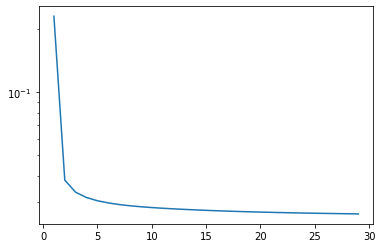

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1,30),g)
plt.yscale('log')